In [2]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parents[0]))
# print(sys.path)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%config Completer.use_jedi = False
%matplotlib inline

import pypole
import numpy as np
import matplotlib.pyplot as plt

from pypole import dipole, maps, fit, convert, compute, plotting

In [2]:
RANDOMSEED = 512

# Tutorial

## Creating a synthetic magnetic map
The dipole module includes 2 functions to create synthetic maps. 

### `calculate_map()`
`calculate_map()` needs a few more input parmaeters such as the grid the map should be calculated for, the location of each source and the magnetic moment of each source.

`calculate_map(x_grid, y_grid, locations, source_vectors, sensor_distance = 5e-6)`

#### map grid
The map grid can be easily calculated by using the `get_grid` function in the `maps` module.

In [3]:
x, y = maps.get_grid(pixel_size=1e-6, pixels=(100, 80))

### single dipole calculation

In [5]:
np.random.seed(RANDOMSEED)  # set randomseed so that the same map is created every time

locations, mag_moments = maps.get_random_sources(9)
single_map = dipole.dipole_field(x, y, *locations[0], *mag_moments[0])

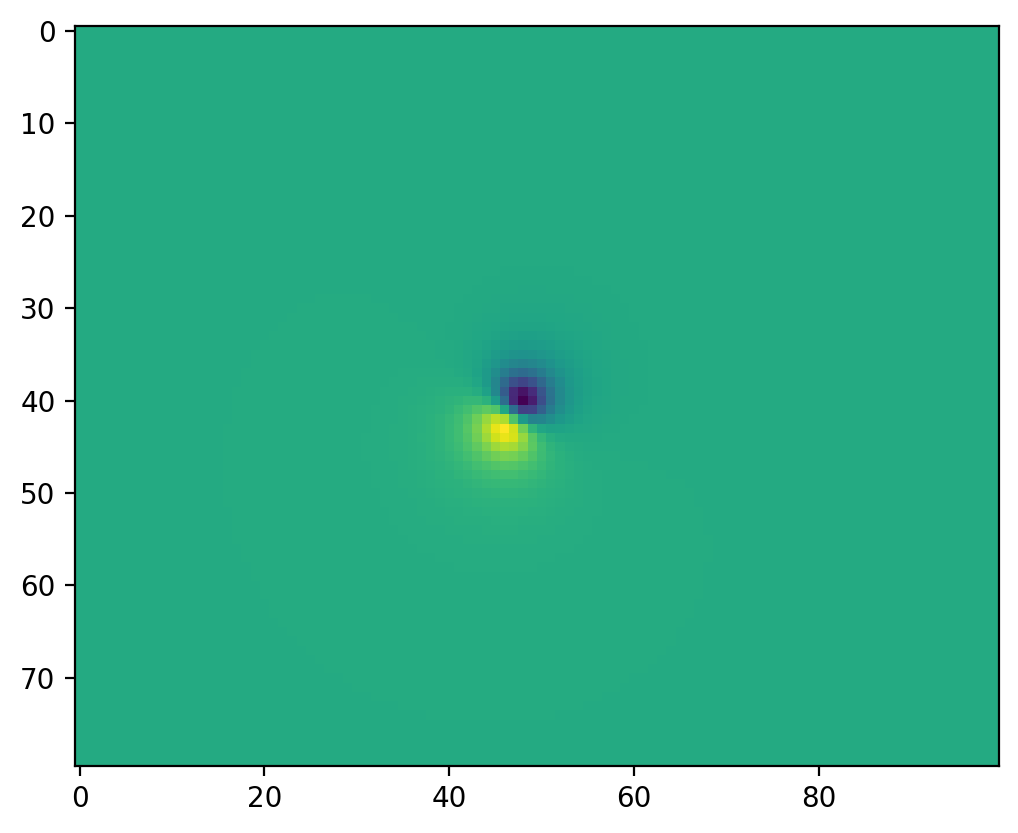

In [6]:
plt.imshow(single_map)

#### source locations and magnetic moments

The location and magnetic moment of the individual sources can be can created by hand or individually using `get_random_locations` and `get_random_dim` in `maps`. To make things easier, there is also a `get_random_sources` function, which creates locations and magnetic moments at the same time.

In [7]:
np.random.seed(RANDOMSEED)  # set randomseed so that the same map is created every time

locations, mag_moments = maps.get_random_sources(9)
d_manual = dipole.calculate_map(x, y, locations, mag_moments)

To calculate the "true" magnetic moment of the source on the map, you can sum up the magnetic moments of the individual sources. This will be the magnetic moment in Am$^2$

In [8]:
print(f"XYZ = {np.sum(mag_moments, axis=0)} Am2")
print(f"Dec = {convert.xyz2dim(np.sum(mag_moments, axis=0))[0,0]:.2f} deg", end="; ")
print(f"Inc = {convert.xyz2dim(np.sum(mag_moments, axis=0))[0,1]:.2f} deg", end="; ")
print(f"Mag = {convert.xyz2dim(np.sum(mag_moments, axis=0))[0,2]:.2e} Am2")

XYZ = [-3.34524267e-15 -5.71770079e-15 -1.59241529e-14] Am2
Dec = 329.67 deg; Inc = 67.41 deg; Mag = 1.72e-14 Am2


This is the map that we have calculated from all the individual sources:

Text(0, 0.5, '$\\mu$m')

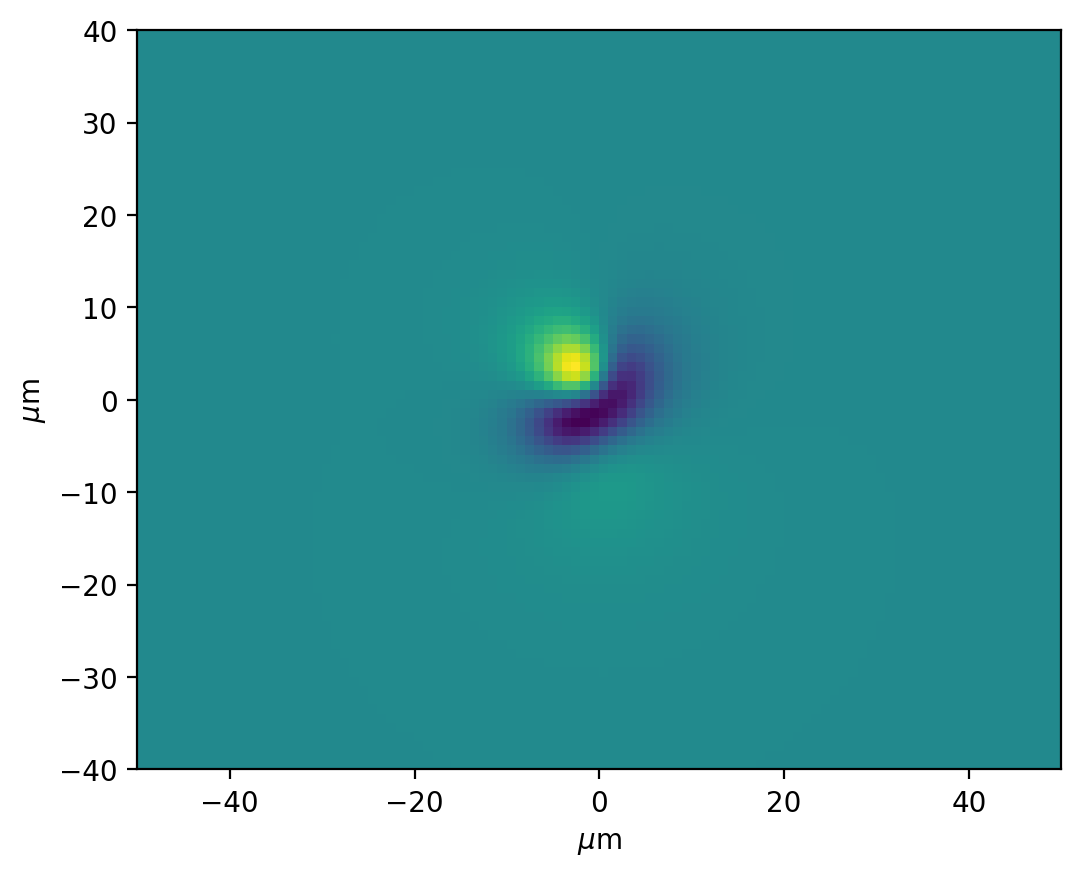

In [9]:
vmin, vmax = np.min(d_manual), np.max(d_manual)
plt.imshow(
    d_manual,
    origin="lower",
    extent=(-x.shape[1] / 2, x.shape[1] / 2, -x.shape[0] / 2, x.shape[0] / 2),
)
plt.xlabel("$\mu$m")
plt.ylabel("$\mu$m")

This map is the sum of these individual sources.

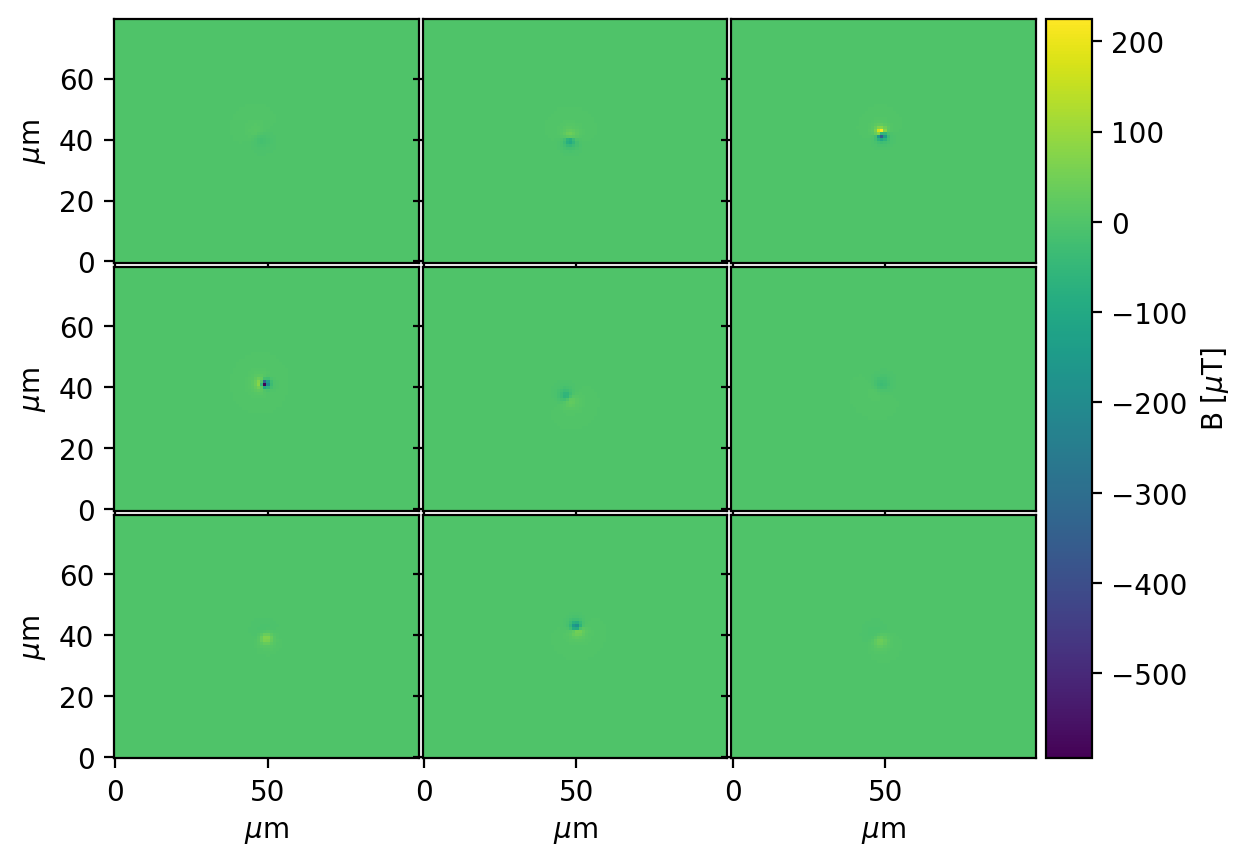

In [11]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure()
ax = ImageGrid(
    fig,
    111,
    nrows_ncols=(3, 3),
    # axes_pad = 0.05,
    cbar_location="right",
    cbar_mode="single",
    cbar_size="5%",
    cbar_pad=0.05,
)
dipoles = np.empty((locations.shape[0], x.shape[0], x.shape[1]))
for i in range(len(locations)):
    dipoles[i, :, :] = dipole.dipole_field(x, y, *locations[i], *mag_moments[i]) * 1e6
vmax = np.max(dipoles)
vmin = np.min(dipoles)
for i in range(len(locations)):
    l = ax[i].imshow(dipoles[i], vmin=vmin, vmax=vmax, origin="lower")
    ax[i].set_xlabel("$\mu$m")
    ax[i].set_ylabel("$\mu$m")
plt.colorbar(l, cax=ax.cbar_axes[0], label="B [$\mu$T]")

### `synthetic_map()` 
is a more simple way of creating a synthetic map. It uses default parameters to create the grid, sopurces and locations for you. Howver, there is still some control about how many sources are created.

`synthetic_map(n_sources = 100, pixels = 100, sensor_distance = 5e-6, pixel_size = 1e-6)`

You can change the number of sources, pixels, the pixel size and the distance of the sample to the sensor.

Here, we will recreate the map from above so we set `n_sources` to 9 just like above.

In [12]:
np.random.seed(RANDOMSEED)  # reset seed to create same map as above
d_simple = dipole.synthetic_map(n_sources=9)  # simple maps create a rectangular map

As you can see the both methods create the same map (given the same state of the ranbdomseed), as `synthetic_map` actually calls `calculate_map` internally.

Text(0.5, 1.0, 'simple map')

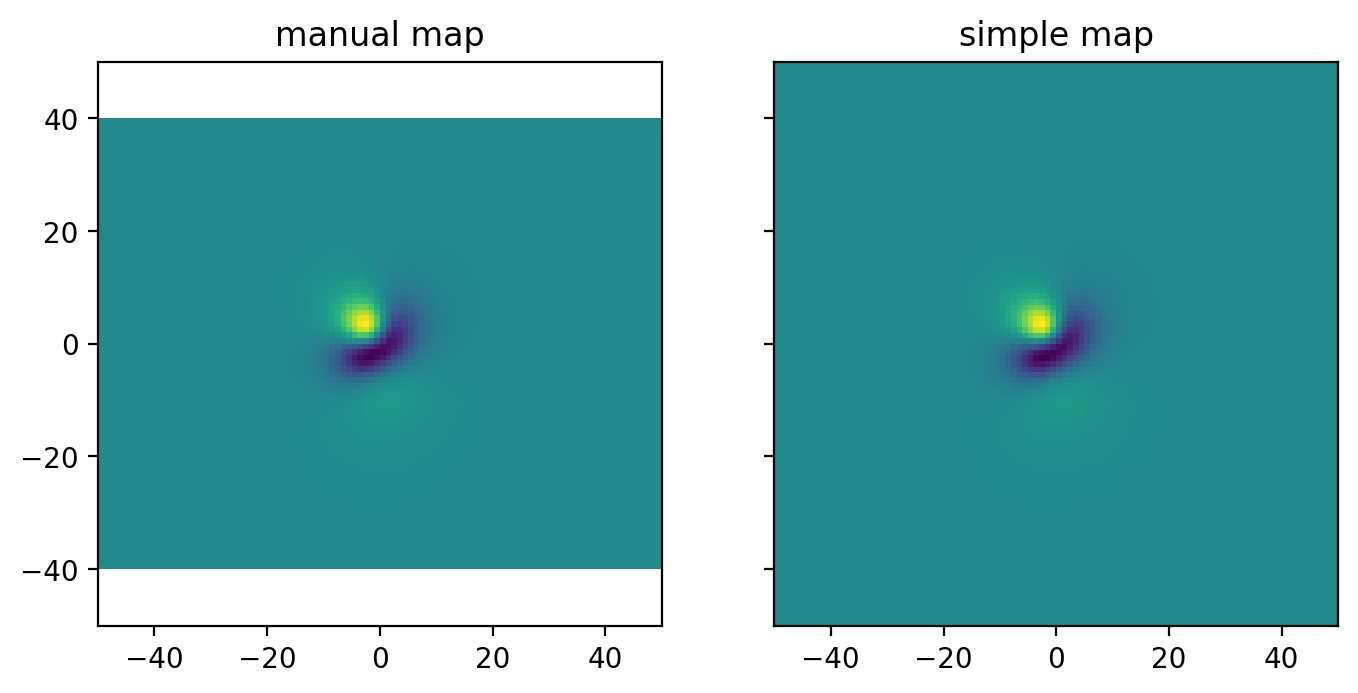

In [13]:
f, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
vmin, vmax = np.min(d_simple), np.max(d_simple)
ax[0].imshow(
    d_manual,
    origin="lower",
    extent=(-x.shape[1] / 2, x.shape[1] / 2, -x.shape[0] / 2, x.shape[0] / 2),
)
ax[0].set_title("manual map")
ax[1].imshow(
    d_simple,
    origin="lower",
    extent=(-x.shape[1] / 2, x.shape[1] / 2, -x.shape[1] / 2, x.shape[1] / 2),
)
ax[1].set_title("simple map")

# Fitting a dipole to a map

Here we use the synthetic map we created previously. To fit the map, we need to create an x and y grid, as well as a initial guess (P0).

In [14]:
fitted_dp = fit.fit_dipole(
    field_map=d_manual, p0=[0, 0, 1e-6, *np.sum(mag_moments, axis=0)], pixel_size=1e-6
)
fitted_simple = fit.fit_dipole(
    field_map=d_simple, p0=[0, 0, 1e-6, *np.sum(mag_moments, axis=0)], pixel_size=1e-6
)

In [15]:
list(zip(fitted_dp.x, fitted_simple.x, fitted_dp.x - fitted_simple.x))

[(-1.993294490168023e-06, -1.993203171808968e-06, -9.131835905500259e-11),
 (1.6716778849390091e-06, 1.671589469191803e-06, 8.841574720610802e-11),
 (4.997732410815995e-06, 4.997591005931381e-06, 1.4140488461416873e-10),
 (-4.211010439503467e-15, -4.210786745576103e-15, -2.2369392736369664e-19),
 (7.013608121056038e-15, 7.0131022773031345e-15, 5.058437529036405e-19),
 (5.526535573172514e-16, 5.5231307563476e-16, 3.404816824913482e-19)]

residual: max: 2.43e-06 std: 2.61e-07 T
dipolarity parameter: 0.45


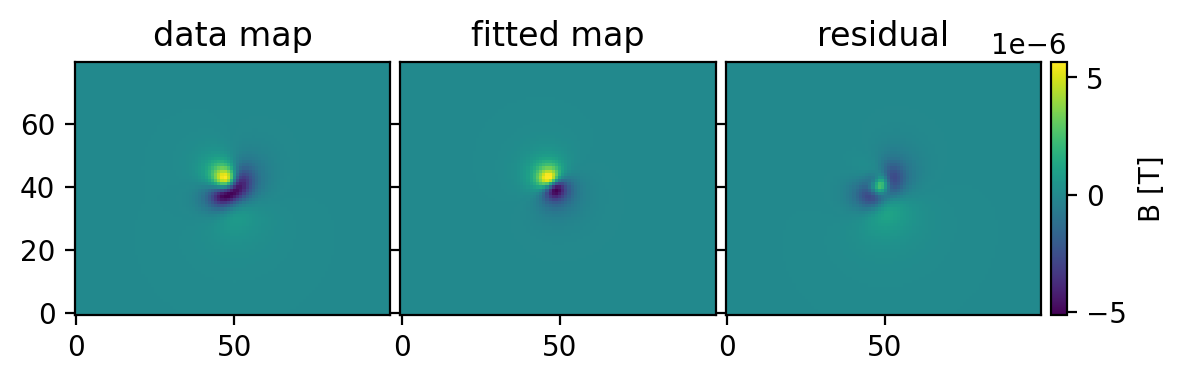

In [16]:
dfit = dipole.dipole_field(x, y, *fitted_dp.x)
plotting.plot_fit(d_manual, dfit)

In [29]:
dp_factor = {}
for i, distance in enumerate(np.linspace(0,10, 10)):
    distance = distance*1e-6 # convert to m
    print(f'\rfitting {distance}', end='')
    uc_map = compute.upward_continue(d_manual, distance)
    param = fit.fit_dipole(field_map=uc_map, p0=[0, 0, 1e-6, 0, 1e-10,0], pixel_size=1e-6)
    dfit = dipole.dipole_field(x, y, *param.x)
    dp_factor[i] = {'distance':distance,
        'dp': compute.dipolarity_param(field_map=uc_map, fitted_map=dfit),
                          'uc_map' : uc_map,
                          'params' : param,
                          'fitted_map' : dfit}

fitting 9.999999999999999e-066

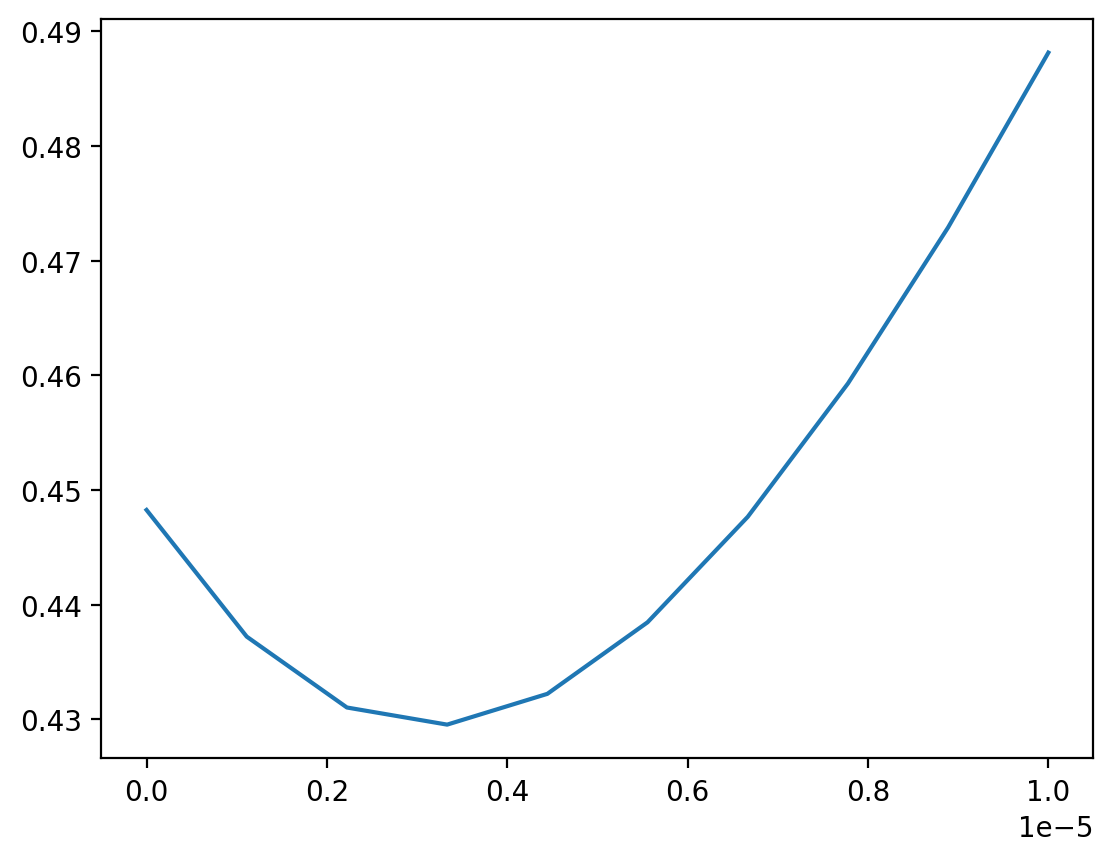

In [30]:
plt.plot([dp_factor[d]['distance'] for d in dp_factor], [dp_factor[d]['dp'] for d in dp_factor])

In [35]:
dp_factor[9]['distance']

9.999999999999999e-06

residual: max: 1.46e-07 std: 3.00e-08 T
dipolarity parameter: 0.49


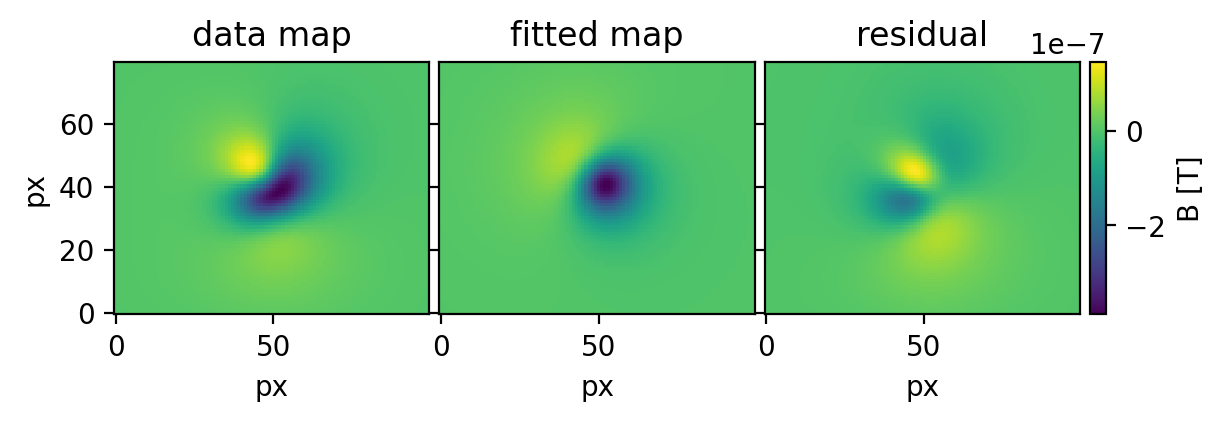

In [27]:
plotting.plot_fit(dp_factor[9]['uc_map'], dp_factor[9]['fitted_map'])

In [28]:
from scipy.io import savemat

# testing

In [34]:
compare = {'data': d_manual, 'fitted': dp_factor[9]['uc_map']}
savemat('/home/mike/Desktop/matlab_compare.mat', compare)

In [3]:
# np.random.seed(100)  # set randomseed so that the same map is created every time
x, y = maps.get_grid(pixel_size=1e-6, pixels=(100, 80))
locations, mag_moments = maps.get_random_sources(1)
single_map = dipole.dipole_field(x, y, *locations[0], *mag_moments[0])
single_map_uc = dipole.dipole_field(x, y, *(locations[0]+[0,0,8e-6]), *mag_moments[0])

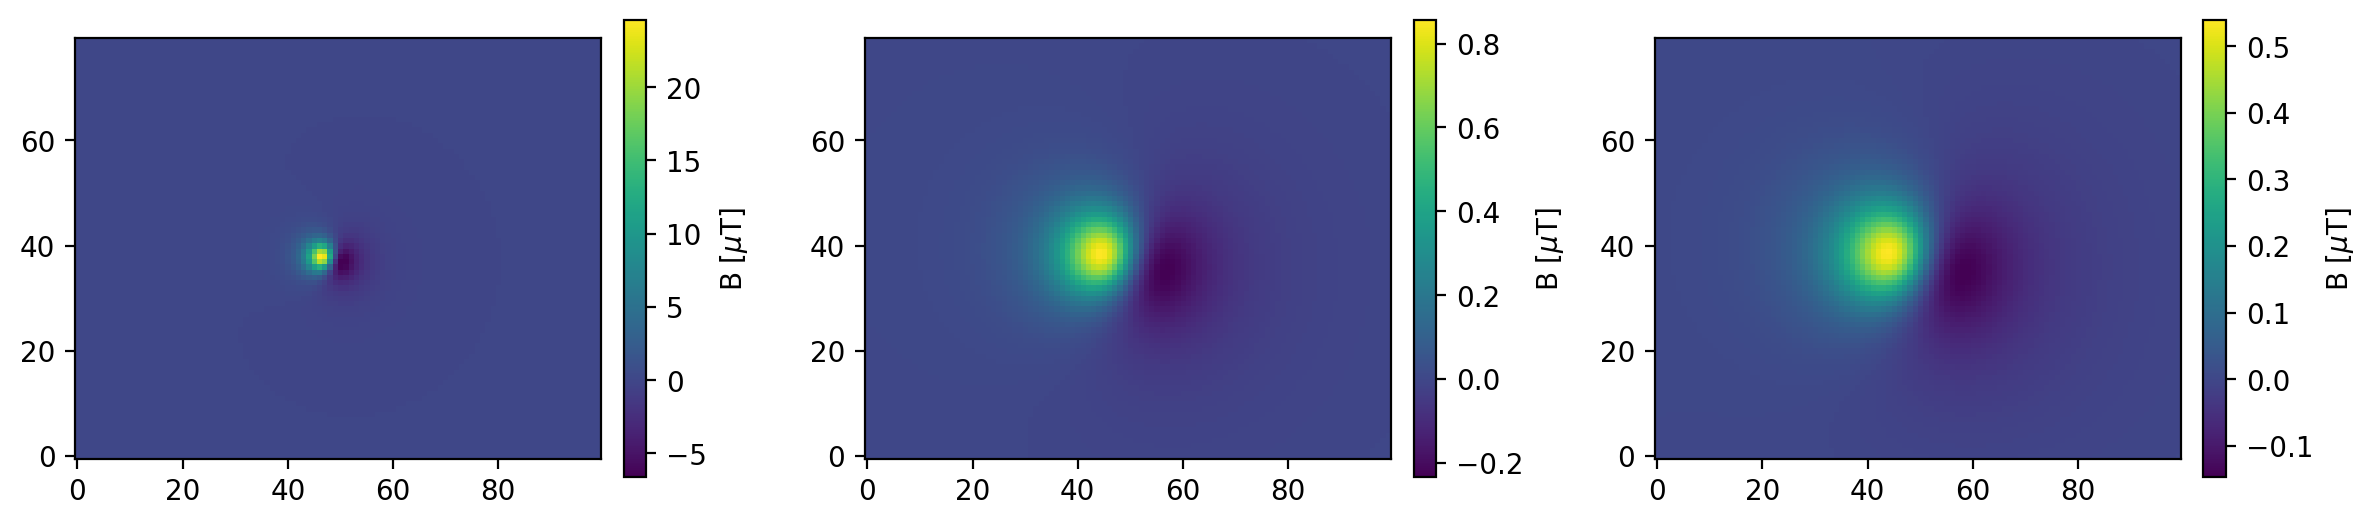

In [4]:
f, ax = plt.subplots(1,3, figsize = (12,4), sharex=False, sharey=False)

im = ax[0].imshow(1e6*single_map, origin='lower')
plt.colorbar(im, ax=ax[0], label='B [$\mu$T]', fraction=0.04, pad=0.04)
im = ax[1].imshow(1e6*single_map_uc, origin='lower')
plt.colorbar(im, ax=ax[1], label='B [$\mu$T]', fraction=0.04, pad=0.04)
im = ax[2].imshow(1e6*(compute.upward_continue(single_map, 10e-6, pixel_size=1e-6)), origin='lower')
plt.colorbar(im, ax=ax[2], label='B [$\mu$T]', fraction=0.04, pad=0.04)
plt.tight_layout()

In [48]:
m = []
d1 = dipole.dipole_field(x, y, *(locations[0]+[0,0,10e-6]), *mag_moments[0])
for d in np.linspace(9.9, 10.3, 10000):
    d2 = compute.upward_continue(single_map, distance=d*1e-6, pixel_size=1e-6)
    # print(f'distance: {d} um, delta: {np.sum(np.abs(d1-d2))}')
    m.append(np.mean(np.abs(d1-d2)))

In [49]:
mn = np.linspace(9.9, 10.1, 10000)[np.argmin(m)]
mn-10

-0.09999999999999964

In [42]:
d1 = dipole.dipole_field(x, y, *(locations[0]+[0,0,10e-6]), *mag_moments[0])
d2 = compute.upward_continue(single_map, distance=mn*1e-6, pixel_size=1e-6)

residual: max: 9.53e-10 std: 3.85e-10 T
dipolarity parameter: 0.99


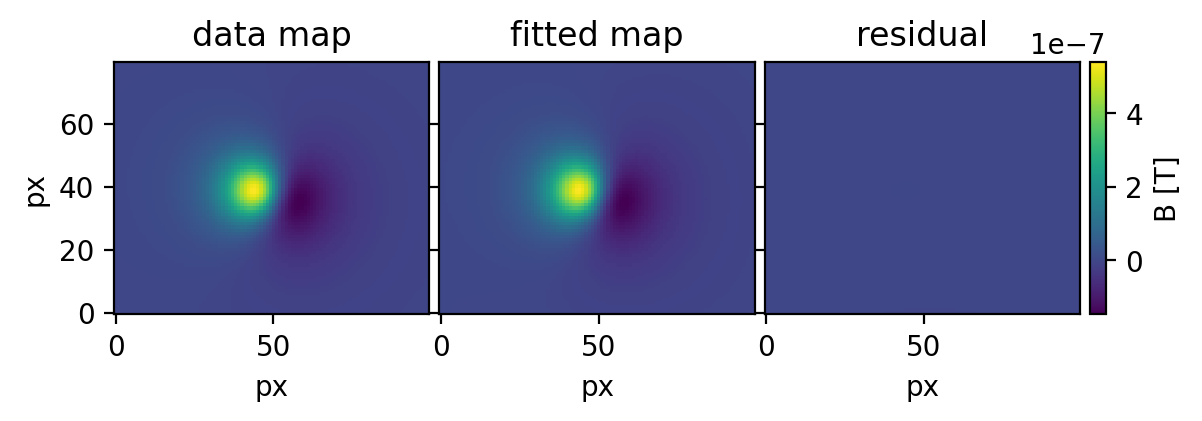

In [43]:
plotting.plot_fit(d1, d2)